In [1]:
import pandas as pd
import os
import pickle
import numpy as np
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import wkt
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Functions

In [2]:
def plot_comparison_maps(df, col1, col2, title1, title2):
    fig, ax = plt.subplots(1, 2, figsize  = (15, 12))
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    df.plot(column = col1, 
            ax = ax[0], 
            figsize = (10, 10))
    ax[0].set_title(title1)
    df.plot(column = col2, 
            ax = ax[1], 
            figsize = (10, 10),
             legend=True,
            legend_kwds={'orientation': "vertical"},
            cax = cax)
    ax[1].set_title(title2)

### Load Data

In [3]:
data_dir = '/Users/saraprice/Documents/NYU/Research/EV Charging Stations/Data'

In [4]:
##EV Charging stations data
EV_df = pd.read_csv(os.path.join(data_dir, 'EV_Charging_Stations_NYC_Open_Data.csv'))
#Zip code boundaries (GIS data for plotting)
zip_boundaries = gpd.read_file(os.path.join(data_dir, 'ZIP_CODE_040114', 'ZIP_CODE_040114.shp'))
#Reference file for NYC zip codes
NYC_zips = pd.read_csv(os.path.join(data_dir, 'NYC_zip_codes.csv'))
#Median income data
income_data = pd.read_csv(os.path.join(data_dir, 'median_income.csv'))
#Poverty data
poverty_data = pd.read_csv(os.path.join(data_dir, 'poverty_census_data_clean.csv'))
#Demo data
demo_data = pd.read_csv(os.path.join(data_dir, 'demo_data_acs_5yr_clean.csv'))

In [5]:
NYC_zips = NYC_zips[['zip_code']]
NYC_zips['zip_code'] = NYC_zips['zip_code'].astype(str).apply(lambda x: str.zfill(x, 5))
NYC_zips.drop_duplicates(inplace = True)
NYC_zips.shape

(240, 1)

In [6]:
##Clean up EV data
EV_df = EV_df[['Station Name', 'Street Address', 'City', 'ZIP']]
EV_df.rename(columns = {"Station Name": 'station_name',
                        "Street Address":'str_address',
                        "City": 'city',
                        'ZIP': 'zip_code'}, inplace = True)
EV_df['zip_code'] = EV_df['zip_code'].astype(str).apply(lambda x: str.zfill(x, 5))

In [7]:
EV_by_zip = EV_df[['station_name', 'zip_code']].groupby(['zip_code']).count().reset_index()\
                    .rename(columns = {'station_name':'station_count'})
EV_by_zip.shape

(104, 2)

In [8]:
#Add in all zip codes in NYC
EV_by_zip = EV_by_zip.merge(NYC_zips, on = ['zip_code'], how = 'right')
print(EV_by_zip.shape)

(240, 2)


In [9]:
#limit to just incomes in NYC
incomes_nyc = income_data[income_data.zip_code.isin(NYC_zips.zip_code)]
incomes_nyc['families_median_income'] = np.where(incomes_nyc['families_median_income']=='250,000+', 250000, 
                                             incomes_nyc['families_median_income'])
incomes_nyc = incomes_nyc[incomes_nyc['families_median_income']!='-']
incomes_nyc['families_median_income'] = incomes_nyc['families_median_income'].astype(int)
incomes_nyc['zip_code'] = incomes_nyc['zip_code'].astype(str).apply(lambda x: str.zfill(x, 5))
incomes_nyc.shape

(176, 2)

### Combine Median Income Data

In [10]:
print(EV_by_zip.shape)
print(incomes_nyc.shape)
EV_income = pd.merge(EV_by_zip, incomes_nyc, on = 'zip_code', how = 'outer')
print(EV_income.shape)
EV_income['families_median_income'] = EV_income['families_median_income'] #.fillna(0)
#EV_income['station_count'] = EV_income['station_count'].fillna(0)

(240, 2)
(176, 2)
(240, 3)


In [11]:
EV_income.corr()

,station_count,families_median_income
station_count,1.000000,0.608508
families_median_income,0.608508,1.000000


In [12]:
EV_income.sort_values('families_median_income', inplace = True)

Text(0.5, 1.0, 'Number of Charging Stations v. Family Median Income')

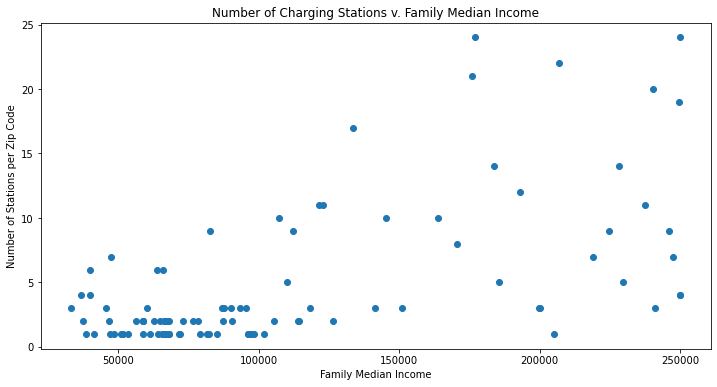

In [13]:
fig = plt.figure(figsize = (12, 6))
plt.scatter(EV_income['families_median_income'], EV_income['station_count'])
plt.xlabel("Family Median Income")
plt.ylabel("Number of Stations per Zip Code")
plt.title("Number of Charging Stations v. Family Median Income")

In [14]:
zip_boundaries['zip_code'] = zip_boundaries['ZIPCODE'].astype(str).apply(lambda x: str.zfill(x, 5))
EV_income_geo = EV_income.merge(zip_boundaries[['zip_code', 'geometry']], on = 'zip_code')
EV_income_geo = gpd.GeoDataFrame(EV_income_geo)
EV_income_geo.shape
EV_income_geo.head()

,zip_code,station_count,families_median_income,geometry
0,10474,NaN,25429.0,"POLYGON ((1013195.257 236528.504, 1013275.073 ..."
1,10454,NaN,30076.0,"POLYGON ((1003141.991 233636.648, 1003154.279 ..."
2,10460,3.0,33282.0,"POLYGON ((1018310.719 250944.480, 1018315.165 ..."
3,10453,NaN,33760.0,"POLYGON ((1011926.556 251674.453, 1011791.220 ..."
4,10455,NaN,33920.0,"POLYGON ((1010994.592 237596.807, 1011063.197 ..."


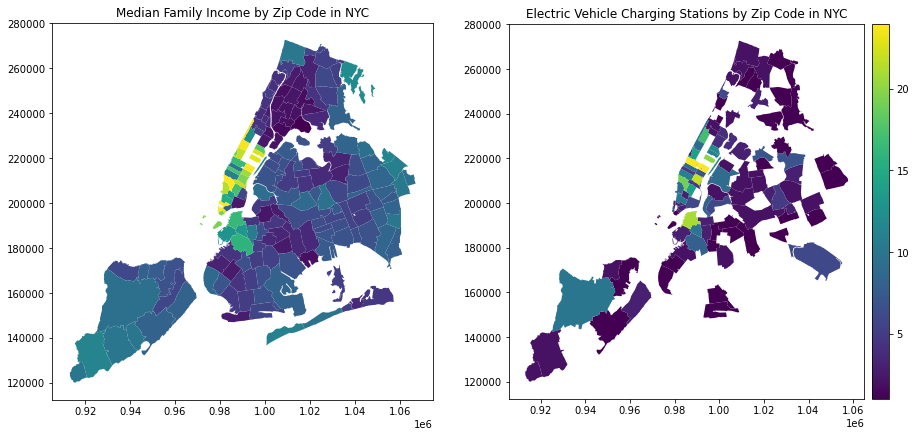

In [15]:
plot_comparison_maps(EV_income_geo, 'families_median_income', 'station_count', 
                     "Median Family Income by Zip Code in NYC", 
                     "Electric Vehicle Charging Stations by Zip Code in NYC")

### Poverty Rate Analysis

In [16]:
poverty_data['zip_code'] = poverty_data['zip_code'].astype(str).apply(lambda x: str.zfill(x, 5))
poverty_nyc = pd.merge(poverty_data, NYC_zips, on = 'zip_code')
print(poverty_nyc.shape)

(205, 4)


In [17]:
print(EV_by_zip.shape)
print(poverty_nyc.shape)
EV_poverty = pd.merge(poverty_nyc, EV_by_zip, on = 'zip_code', how = 'outer')
EV_poverty['poverty_rate'] = EV_poverty['poverty_rate'] #.fillna(0)
EV_poverty['non_poverty_rate'] = 1- EV_poverty['poverty_rate']
EV_poverty['station_count'] = EV_poverty['station_count'] #.fillna(0)
print(EV_poverty.shape)

(240, 2)
(205, 4)
(240, 6)


In [18]:
EV_poverty.corr()

,count_poverty_level_determined,count_below_poverty_level,poverty_rate,station_count,non_poverty_rate
count_poverty_level_determined,1.000000,0.815824,0.503246,-0.037812,-0.503246
count_below_poverty_level,0.815824,1.000000,0.746467,-0.237886,-0.746467
poverty_rate,0.503246,0.746467,1.000000,-0.232831,-1.000000
station_count,-0.037812,-0.237886,-0.232831,1.000000,0.232831
non_poverty_rate,-0.503246,-0.746467,-1.000000,0.232831,1.000000


In [19]:
EV_poverty_geo = EV_poverty.merge(zip_boundaries[['zip_code', 'geometry']], on = 'zip_code')
EV_poverty_geo = gpd.GeoDataFrame(EV_poverty_geo)

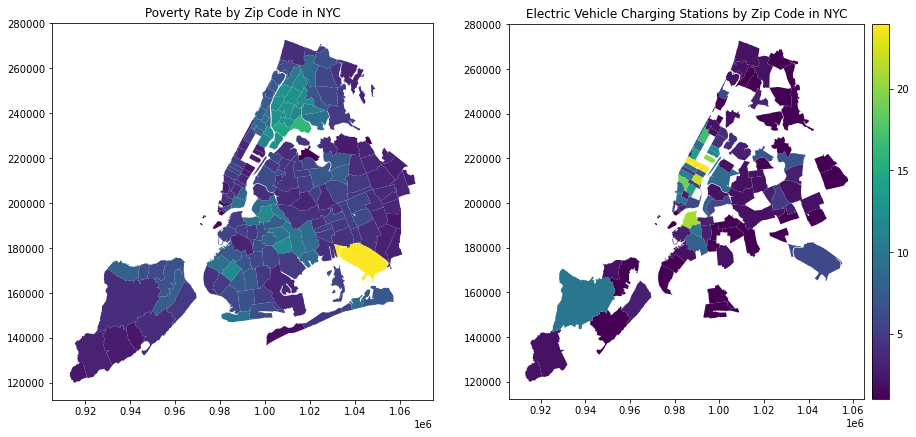

In [20]:
plot_comparison_maps(EV_poverty_geo, 'poverty_rate', 'station_count', 
                    "Poverty Rate by Zip Code in NYC",
                    "Electric Vehicle Charging Stations by Zip Code in NYC")


### Racial Demography Analysis

In [21]:
demo_data['zip_code'] = demo_data['zip_code'].astype(str).apply(lambda x: str.zfill(x, 5))
demo_nyc = pd.merge(demo_data, NYC_zips, on = 'zip_code') 
demo_nyc.shape

(205, 12)

In [22]:
EV_demo = pd.merge(demo_nyc, EV_by_zip, on = 'zip_code', how = 'outer')
EV_demo = EV_demo #.fillna(0)
EV_demo.shape

(240, 13)

In [23]:
EV_demo.drop([col for col in EV_demo.columns if col.find("pop")>0], inplace = True, axis = 1)
EV_demo.corr() 

,white_perc,black_perc,native_american_perc,asian_perc,hispanic_perc,station_count
white_perc,1.000000,-0.429451,-0.107761,0.218785,-0.070671,0.416295
black_perc,-0.429451,1.000000,0.255302,-0.331437,0.182859,-0.283502
native_american_perc,-0.107761,0.255302,1.000000,0.090904,0.526934,-0.112771
asian_perc,0.218785,-0.331437,0.090904,1.000000,-0.055125,0.013730
hispanic_perc,-0.070671,0.182859,0.526934,-0.055125,1.000000,-0.345013
station_count,0.416295,-0.283502,-0.112771,0.013730,-0.345013,1.000000


In [25]:
EV_demo.columns

Index(['zip_code', 'white_perc', 'black_perc', 'native_american_perc',
       'asian_perc', 'hispanic_perc', 'station_count'],
      dtype='object')

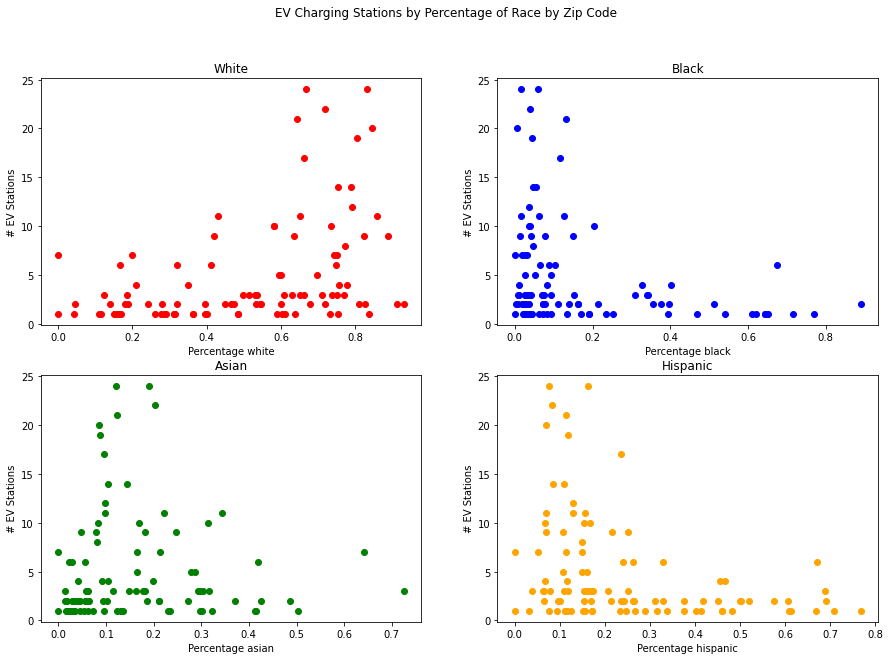

In [24]:
axs = {}
races = ['white', 'black', 'asian', 'hispanic']
fig, ((axs[0], axs[1]), (axs[2], axs[3])) = plt.subplots(2,2, figsize = (15,10))
fig.suptitle("EV Charging Stations by Percentage of Race by Zip Code")
i = 0
colors = ['red', 'blue', 'green', 'orange']
for race in races:
    axs[i].scatter(EV_demo[f'{race}_perc'], EV_demo['station_count'], color = colors[i])
    axs[i].set(ylabel = '# EV Stations', xlabel = f"Percentage {race}", title = "{}".format(str.title(race)))
    i+=1

In [38]:
print(EV_demo.columns)
print(zip_boundaries.columns)
EV_demo_geo = EV_demo.merge(zip_boundaries[['zip_code', 'geometry']], on = 'zip_code')

EV_demo_geo = gpd.GeoDataFrame(EV_demo_geo)

Index(['zip_code', 'white_perc', 'black_perc', 'native_american_perc',
       'asian_perc', 'hispanic_perc', 'station_count'],
      dtype='object')
Index(['ZIPCODE', 'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry', 'zip_code'],
      dtype='object')


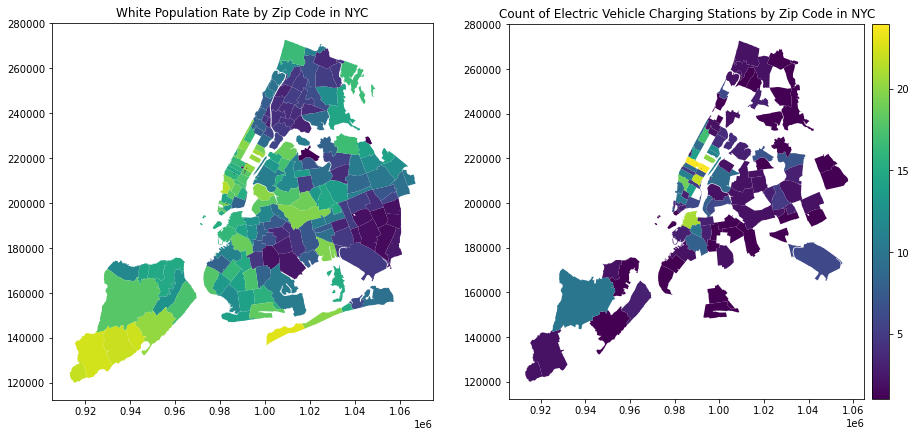

In [39]:
plot_comparison_maps(EV_demo_geo, 'white_perc', 'station_count', 
                     "White Population Rate by Zip Code in NYC", 
                     "Count of Electric Vehicle Charging Stations by Zip Code in NYC")

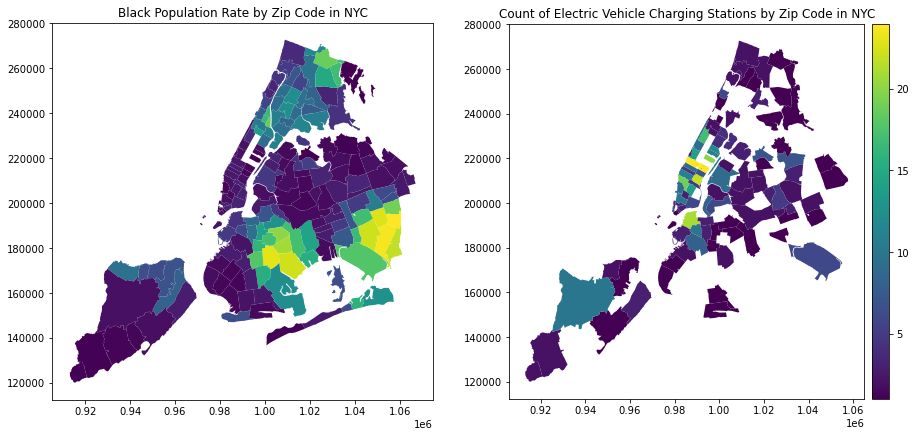

In [40]:
plot_comparison_maps(EV_demo_geo, 'black_perc', 'station_count', 
                     "Black Population Rate by Zip Code in NYC", 
                     "Count of Electric Vehicle Charging Stations by Zip Code in NYC")

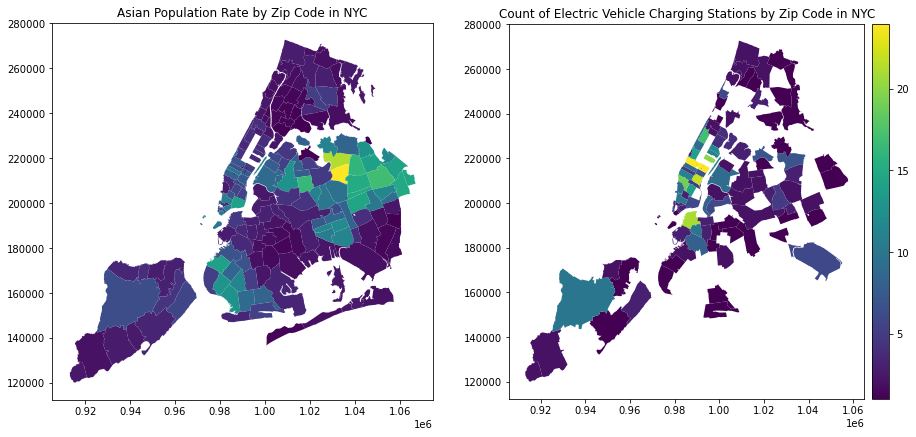

In [41]:
plot_comparison_maps(EV_demo_geo, 'asian_perc', 'station_count', 
                     "Asian Population Rate by Zip Code in NYC", 
                     "Count of Electric Vehicle Charging Stations by Zip Code in NYC")

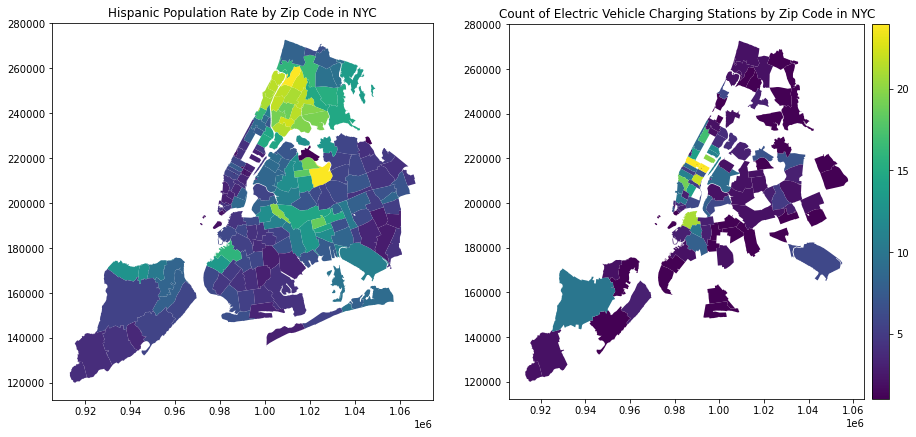

In [42]:
plot_comparison_maps(EV_demo_geo, 'hispanic_perc', 'station_count', 
                     "Hispanic Population Rate by Zip Code in NYC", 
                     "Count of Electric Vehicle Charging Stations by Zip Code in NYC")

In [26]:
print(EV_poverty.shape)
print(EV_income.shape)
EV_comb = pd.merge(EV_poverty[['station_count', 'poverty_rate', 'zip_code']], EV_income, 
                   on = ['zip_code', 'station_count'], how = 'left')
print(EV_comb.shape)
EV_comb = pd.merge(EV_comb, EV_demo, on = ['zip_code', 'station_count'])
EV_comb['station_present'] = np.where(EV_comb['station_count']>0, 1, 0)
print(EV_comb['zip_code'].drop_duplicates().shape)
print(EV_comb.shape)
EV_comb.drop('zip_code', axis = 1, inplace = True)
EV_comb.fillna(0, inplace = True)
EV_comb.shape

(240, 6)
(240, 3)
(240, 4)
(240,)
(240, 10)


(240, 9)

### Descriptive Statistics on Station v. Non-Station Zip Codes

In [27]:
EV_comb.station_present.value_counts()

0    136
1    104
Name: station_present, dtype: int64

In [29]:
no_station.describe()

NameError: name 'no_station' is not defined

<AxesSubplot:title={'center':'families_median_income'}, xlabel='station_present'>

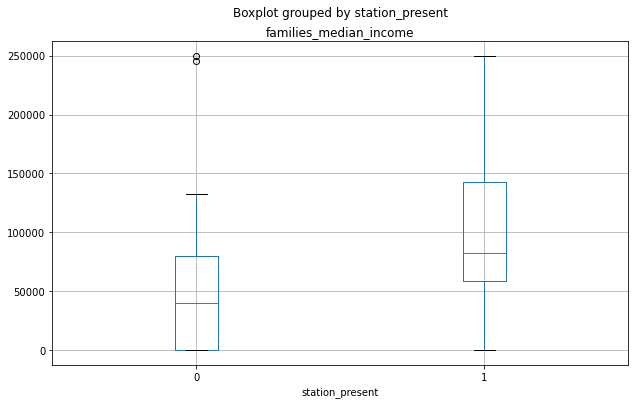

In [30]:
EV_comb.boxplot('families_median_income', by = 'station_present', figsize = (10, 6))

<AxesSubplot:title={'center':'poverty_rate'}, xlabel='station_present'>

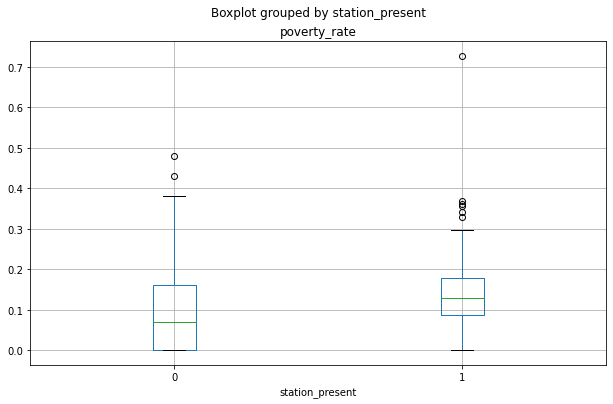

In [31]:
EV_comb.boxplot('poverty_rate', by = 'station_present', figsize = (10, 6))

array([[<AxesSubplot:title={'center':'asian_perc'}, xlabel='[station_present]'>,
        <AxesSubplot:title={'center':'black_perc'}, xlabel='[station_present]'>],
       [<AxesSubplot:title={'center':'hispanic_perc'}, xlabel='[station_present]'>,
        <AxesSubplot:title={'center':'white_perc'}, xlabel='[station_present]'>]],
      dtype=object)

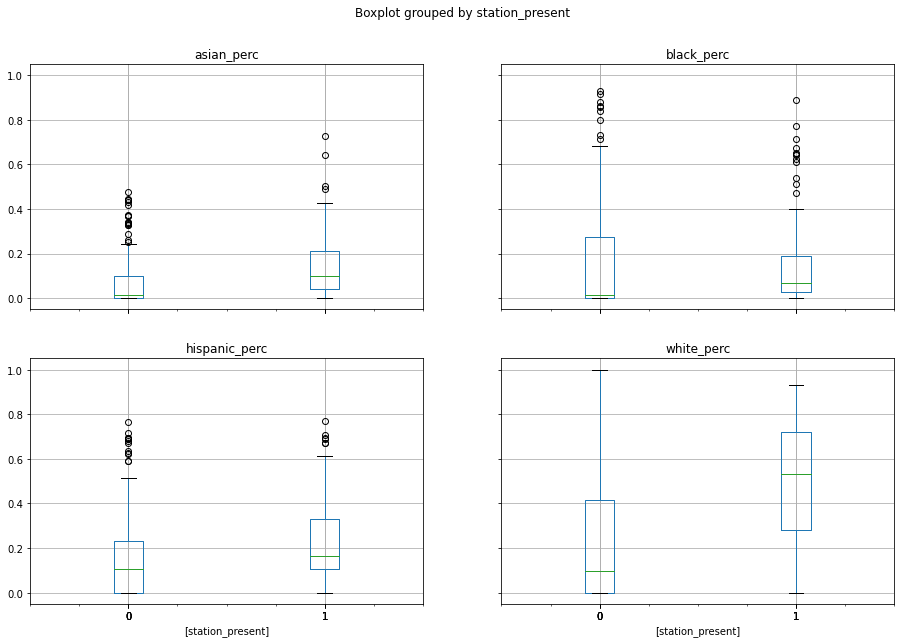

In [32]:
EV_comb[['station_present', 'white_perc', 'black_perc', 'asian_perc', 'hispanic_perc']].boxplot( by = 'station_present', figsize = (15, 10))

### Logistic Regression

In [33]:
X = EV_comb.drop(['station_count', 'station_present'], axis = 1)
X = X.iloc[np.ravel(np.where(np.sum(np.array(X), axis = 1)>0)),:]
print(X.shape)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
Y = np.array(EV_comb[['station_present']].iloc[np.ravel(np.where(np.sum(np.array(X), axis = 1)>0)),:])
Y.shape

(178, 7)


(178, 1)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.25)

In [35]:
LR = LogisticRegression().fit(X_train, y_train) 

lr_score = LR.predict_proba(X_test)
lr_preds = LR.predict(X_test)
LR.score(X_test, y_test)

0.5777777777777777

In [84]:
np.ravel(y_test)

array([1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1])

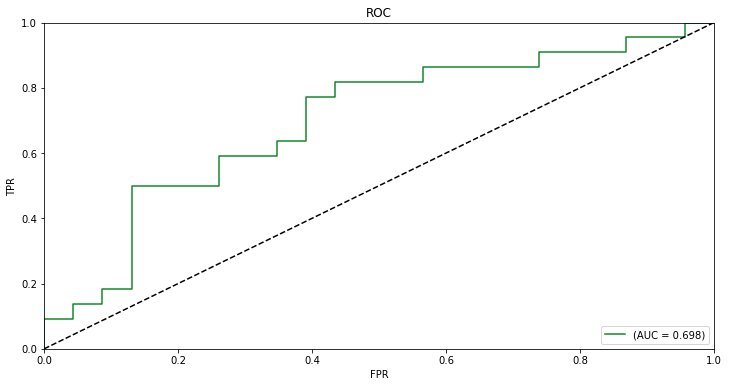

In [85]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (12,6))
fpr, tpr, thresholds = roc_curve(np.ravel(y_test), lr_score[:,1])
roc_auc = auc(fpr, tpr)

#chooses a random color for plotting
c = (np.random.rand(), np.random.rand(), np.random.rand())

#plot current model ROC curve
plt.plot(fpr, tpr, color = c, label ='(AUC = %0.3f)' % roc_auc) 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## Conditional Analysis

In [53]:
inc_percentiles = np.percentile(EV_comb[EV_comb['families_median_income']!=0.0]['families_median_income'],\
                                np.arange(0, 100, 10) )
inc_percentiles


array([ 25429. ,  41301.5,  53586. ,  64928. ,  71506. ,  80081. ,
        89181. , 100483. , 121625. , 199986.5])

In [47]:
### Percentage White 

176

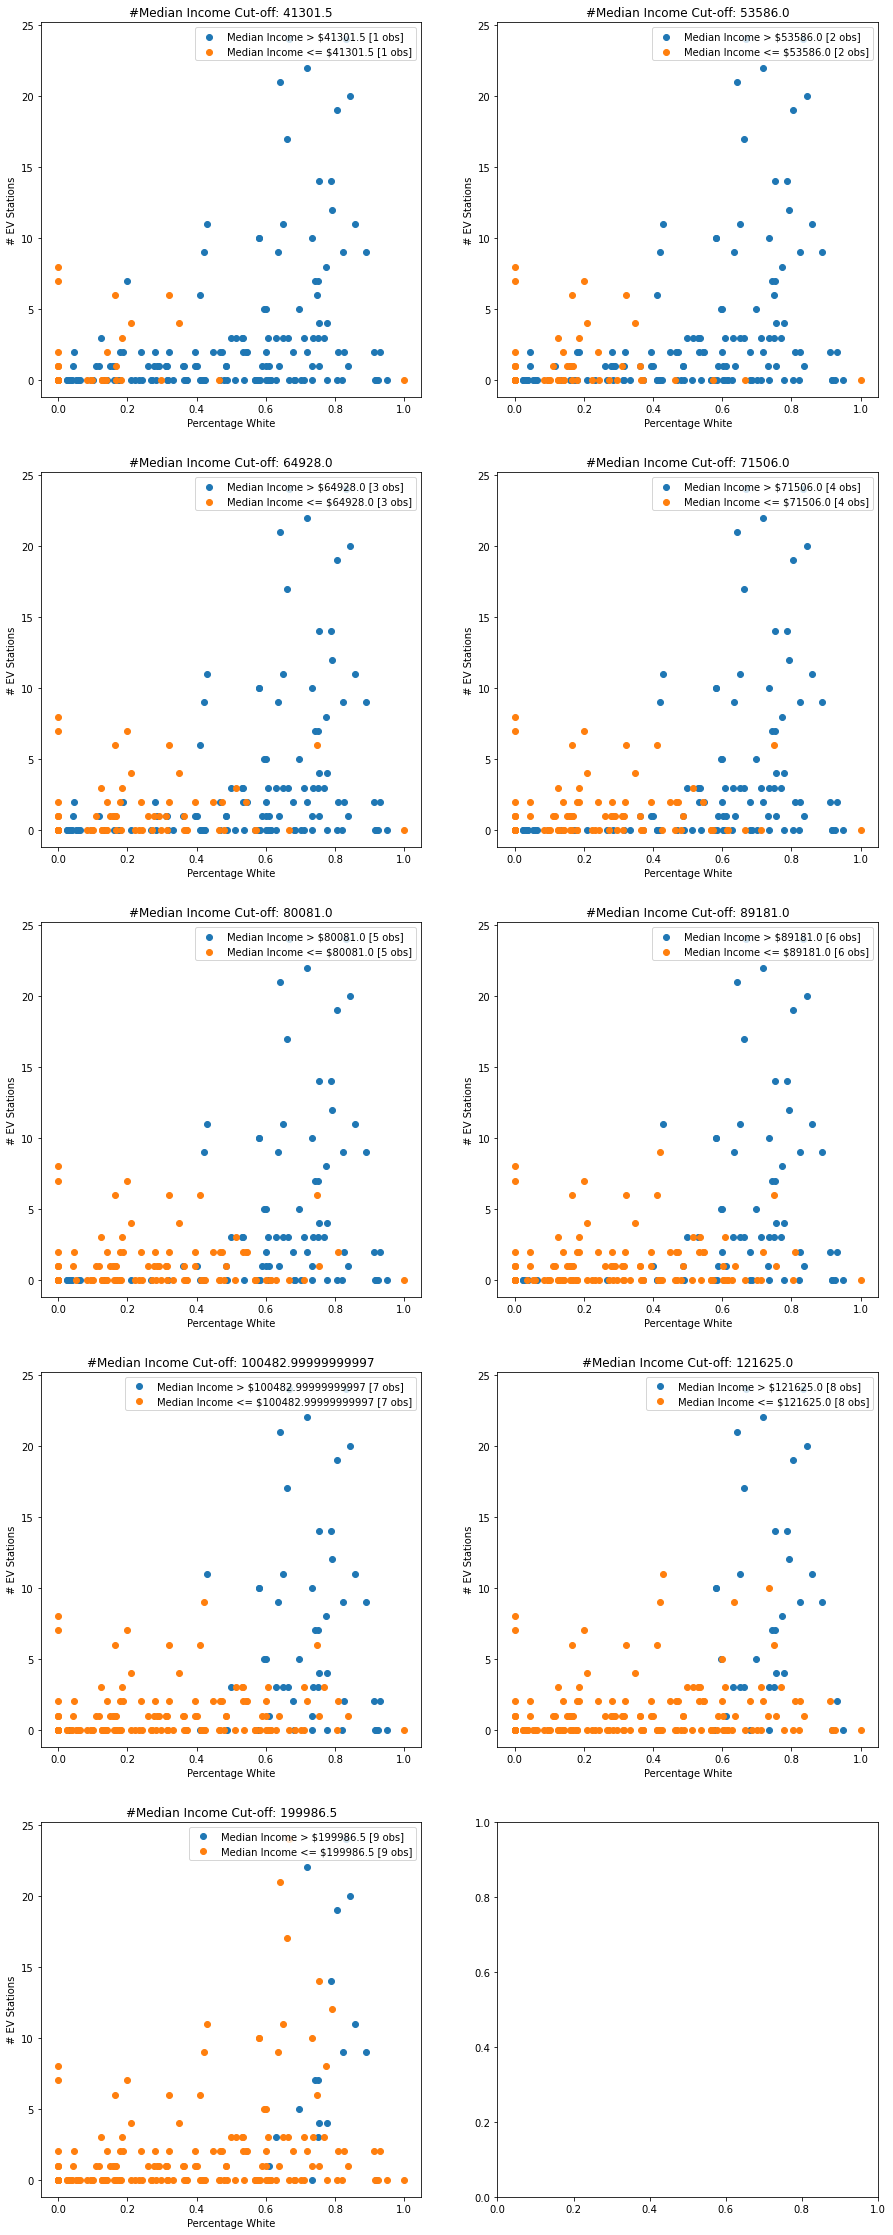

In [73]:
axs = {} 
fig, ((axs[0], axs[1]), (axs[2], axs[3]),(axs[4], axs[5]), (axs[6], axs[7]), (axs[8], axs[9])) = plt.subplots(5,2, figsize = (15,40))
i = 0
over_inc = {}
under_inc = {}
for p in np.arange(1, 10):
    over_inc[inc_percentiles[p]] = EV_comb[EV_comb['families_median_income']> inc_percentiles[p]]
    under_inc[inc_percentiles[p]] = EV_comb[EV_comb['families_median_income']<= inc_percentiles[p]]
    axs[i].scatter(over_inc[inc_percentiles[p]]['white_perc'], over_inc[inc_percentiles[p]]['station_count'],
                label = "Median Income > ${} [{} obs]".format(inc_percentiles[p], len(over_inc)))
    axs[i].scatter(under_inc[inc_percentiles[p]]['white_perc'], under_inc[inc_percentiles[p]]['station_count'],
                label = "Median Income <= ${} [{} obs]".format(inc_percentiles[p], len(under_inc)))
    axs[i].set(ylabel = '# EV Stations', xlabel = f"Percentage White", \
               title = "#Median Income Cut-off: {}".format(inc_percentiles[p]))
    axs[i].legend(loc='upper right')
    
    i+=1

#### Correlation

In [80]:
for p in inc_percentiles[1:]:
    print("MEDIAN INCOME CUT OFF: {}".format(p))
    print("Over")
    print(over_inc[p][['white_perc', 'station_count']].corr())
    print("Under")
    print(under_inc[p][['white_perc', 'station_count']].corr())

MEDIAN INCOME CUT OFF: 41301.5
Over
               white_perc  station_count
white_perc       1.000000       0.386132
station_count    0.386132       1.000000
Under
               white_perc  station_count
white_perc        1.00000        0.19435
station_count     0.19435        1.00000
MEDIAN INCOME CUT OFF: 53586.0
Over
               white_perc  station_count
white_perc       1.000000       0.383786
station_count    0.383786       1.000000
Under
               white_perc  station_count
white_perc       1.000000       0.137931
station_count    0.137931       1.000000
MEDIAN INCOME CUT OFF: 64928.0
Over
               white_perc  station_count
white_perc       1.000000       0.368503
station_count    0.368503       1.000000
Under
               white_perc  station_count
white_perc       1.000000       0.246843
station_count    0.246843       1.000000
MEDIAN INCOME CUT OFF: 71506.0
Over
               white_perc  station_count
white_perc       1.000000       0.363606
station_count    0

In [77]:
axs = {} 
fig, ((axs[0], axs[1]), (axs[2], axs[3]),(axs[4], axs[5]), (axs[6], axs[7]), (axs[8], axs[9])) = plt.subplots(5,2, figsize = (15,40))
i = 0
over_inc = {}
under_inc = {}
for p in np.arange(1, 10):
    over_inc[inc_percentiles[p]] = EV_comb[EV_comb['families_median_income']> inc_percentiles[p]]
    under_inc[inc_percentiles[p]] = EV_comb[EV_comb['families_median_income']<= inc_percentiles[p]]
    axs[i].scatter(over_inc[inc_percentiles[p]]['white_perc'], over_inc[inc_percentiles[p]]['station_count'],
                label = "Median Income > ${} [{} obs]".format(inc_percentiles[p], len(over_inc)))
    axs[i].scatter(under_inc[inc_percentiles[p]]['white_perc'], under_inc[inc_percentiles[p]]['station_count'],
                label = "Median Income <= ${} [{} obs]".format(inc_percentiles[p], len(under_inc)))
    axs[i].set(ylabel = '# EV Stations', xlabel = f"Percentage White", \
               title = "#Median Income Cut-off: {}".format(inc_percentiles[p]))
    axs[i].legend(loc='upper right')
    
    i+=1

array([ 25429. ,  41301.5,  53586. ,  64928. ,  71506. ,  80081. ,
        89181. , 100483. , 121625. , 199986.5])

In [ ]:
non-white percentage horizontal axis, 
verticle axis median income 
different color for above or below 